In [1]:
import os
import music21 as m21
import numpy as np
import pandas as pd
import warnings
from typing import Dict, List, Optional, Sequence, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder
sns.set()
warnings.filterwarnings("ignore")
from fractions import Fraction

In [2]:
dur=[0.25,0.5,0.75,1.,1.5,2.,3.,4.]

In [3]:
path = r"C:\Users\omer-\Desktop\musics"

In [4]:
def load(path):
    songs = []
    for m in os.listdir(path):
        warnings.filterwarnings("ignore")
        if m[-3:] == "MID" or m[-3:] == "mid":
            songs.append(m21.converter.parse((path+"\{}").format(m)))
    return songs

In [5]:
def dataframe(songs):
    x = []
    sizes= []
    for m in songs:
        for s in m:
            notes = [a for a in s.flat.notesAndRests]
            s = 0
            for i in notes:
                s = s+1
                if isinstance(i,m21.note.Note):
                    x.append([i.pitch.midi,float(i.duration.quarterLength)])
                else:
                    x.append([0,float(i.duration.quarterLength)])
            sizes.append(s)
    df = pd.DataFrame(x,columns=["pitch", "duration"])
    return df,sizes

In [6]:
def transpose(m):
    key = m.analyze("key")
    if key.mode == "major":
        interval = m21.interval.Interval(key.tonic,m21.pitch.Pitch("C"))
    if key.mode == "minor":
        interval = m21.interval.Interval(key.tonic,m21.pitch.Pitch("A"))
    
    return m.transpose(interval)      
        

In [7]:
def duration(m,dur):
    for note in  m.flat.notesAndRests:
        if note.duration.quarterLength not in dur:
            return False
    return True

In [8]:
def preprocess(path,dur):
    songs = load(path)
    s = []
    for m in songs:
        if not duration(m,dur):
            continue
        s.append(transpose(m))
    
    return s

In [9]:
def batch(encoded,samp_per_batch=12, seq_len=10):
    note_per_batch = samp_per_batch * seq_len
    num_batches_avail = int(len(encoded)/note_per_batch)
    encoded = encoded[:num_batches_avail * note_per_batch]
    state = True
    for n in range(0, (encoded.shape[0]-seq_len), seq_len):
        if state:
            x = np.array([encoded[n:n+seq_len]])
            y = np.array([encoded[n+1:n+seq_len+1]])
            state = False
            n2 = 0
        else:
            n2 +=1
            x = np.append(x,np.array([encoded[n:n+seq_len]]),axis=0)
            try:
                y= np.append(y,np.array([encoded[n+1:n+seq_len+1]]),axis=0)
            except:
                y= np.append(y,np.array([encoded[n+1:n+seq_len]]),axis=0)
                y= np.append(y,np.array([[encoded[0]]]),axis=0)
            if (n2+1)%samp_per_batch == 0 :
                yield x,y
                state = True

In [10]:
def transform(model,data):
        b = []
        for d in data:
            b.append(model.ohe.transform(d).toarray())
        return np.array(b)

In [92]:
def output(model,arr):
    model.eval()
    arr = transform(model,np.array([arr]))
    hidden = model.hidden_state(1)
    inputs = torch.from_numpy(arr).float()
    inputs = inputs.cuda()
    lstm_output, hidden = model.forward(inputs,hidden)
    lstm_output,_ = model(inputs,hidden)
    q = lstm_output.cpu().detach().clone().numpy()
    return model.ohe.inverse_transform(q)

In [11]:
m = preprocess(path,dur)
df,s = dataframe(m)

In [12]:
len(df)

10995

In [13]:
class noteModel(nn.Module):
    
    def __init__(self, df, num_hidden=256, num_layers=4,drop_prob=0.5,use_gpu=False):
        
        
        super().__init__()
        self.drop_prob = drop_prob
        self.num_layers = num_layers
        self.num_hidden = num_hidden
        self.use_gpu = use_gpu
        
        
        self.df = df
        self.ohe = OneHotEncoder(sparse=True)
        self.ohe.fit_transform(df)
        self.uni = len(self.ohe.get_feature_names())
        
        
        
        self.lstm = nn.LSTM(self.uni, num_hidden, num_layers, dropout=drop_prob,batch_first=True)
        
        self.dropout = nn.Dropout(drop_prob)
        
        self.fc_linear = nn.Linear(num_hidden, self.uni)
      
    
    def forward(self, x, hidden):
                  
        
        lstm_output, hidden = self.lstm(x, hidden)
        
        
        drop_output = self.dropout(lstm_output)
        
        drop_output = drop_output.contiguous().view(-1, self.num_hidden)
        
        
        final_out = self.fc_linear(drop_output)
        
        return final_out, hidden
    
    
    def hidden_state(self, batch_size):
        
        if self.use_gpu:
            
            hidden = (torch.zeros(self.num_layers,batch_size,self.num_hidden).cuda(),
                     torch.zeros(self.num_layers,batch_size,self.num_hidden).cuda())
        else:
            hidden = (torch.zeros(self.num_layers,batch_size,self.num_hidden),
                     torch.zeros(self.num_layers,batch_size,self.num_hidden))
        
        return hidden
    

In [174]:
model = noteModel(
    df=df,
    num_hidden=50,
    num_layers=2,
    drop_prob=0.5,
    use_gpu=True,
)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()
train_data= df.values
val_data= df.values

In [175]:
epochs = 1000
seq_len = 20
batch_size = 5
tracker = 0

In [176]:
# Set model to train
model.train()


# Check to see if using GPU
if model.use_gpu:
    model = model.cuda()

for i in range(epochs):
    
    hidden = model.hidden_state(batch_size)
    
    
    for x,y in batch(train_data,batch_size,seq_len):
        
        tracker += 1
        
        # One Hot Encode incoming data
        x = transform(model,x)
        y = transform(model,y)
        # Convert Numpy Arrays to Tensor
        
        inputs = torch.from_numpy(x).float()
        targets = torch.from_numpy(y).float()
  
        if model.use_gpu:
            
            inputs = inputs.cuda()
            targets = targets.cuda()
            
        hidden = tuple([state.data for state in hidden])
        
        model.zero_grad()
        
        lstm_output, hidden = model.forward(inputs,hidden)
        loss = criterion(lstm_output,targets.view(batch_size*seq_len,-1))
        
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(),max_norm=5)
        
        optimizer.step()
        
        
        #train error
        if tracker % 25 == 0:
            
            val_hidden = model.hidden_state(batch_size)
            val_losses = []
            model.eval()
            
            for x,y in batch(val_data,batch_size,seq_len):
                
                x = transform(model,x)
                y = transform(model,y)

                inputs = torch.from_numpy(x).float()
                targets = torch.from_numpy(y).float()
                
                if model.use_gpu:

                    inputs = inputs.cuda()
                    targets = targets.cuda()
                    
                val_hidden = tuple([state.data for state in val_hidden])
                
                lstm_output, val_hidden = model.forward(inputs,val_hidden)
                val_loss = criterion(lstm_output,targets.view(batch_size*seq_len,-1))
        
                val_losses.append(val_loss.item())
            model.train()
            
            print(f"Epoch: {i} Step: {tracker} Val Loss: {val_loss.item()}")

Epoch: 0 Step: 25 Val Loss: 4.804070472717285
Epoch: 0 Step: 50 Val Loss: 3.880821466445923
Epoch: 0 Step: 75 Val Loss: 3.7391960620880127
Epoch: 0 Step: 100 Val Loss: 3.718372106552124
Epoch: 1 Step: 125 Val Loss: 3.683289051055908
Epoch: 1 Step: 150 Val Loss: 3.750671863555908
Epoch: 1 Step: 175 Val Loss: 3.6769862174987793
Epoch: 1 Step: 200 Val Loss: 3.7200050354003906
Epoch: 2 Step: 225 Val Loss: 3.510504722595215
Epoch: 2 Step: 250 Val Loss: 3.52744460105896
Epoch: 2 Step: 275 Val Loss: 3.5696160793304443
Epoch: 2 Step: 300 Val Loss: 3.6392016410827637
Epoch: 3 Step: 325 Val Loss: 3.502903938293457
Epoch: 3 Step: 350 Val Loss: 3.483776807785034
Epoch: 3 Step: 375 Val Loss: 3.563382148742676
Epoch: 3 Step: 400 Val Loss: 3.58072566986084
Epoch: 3 Step: 425 Val Loss: 3.5757017135620117
Epoch: 4 Step: 450 Val Loss: 3.4149858951568604
Epoch: 4 Step: 475 Val Loss: 3.4950265884399414
Epoch: 4 Step: 500 Val Loss: 3.549862861633301
Epoch: 4 Step: 525 Val Loss: 3.6357505321502686
Epoch: 5 

Epoch: 39 Step: 4225 Val Loss: 1.759639859199524
Epoch: 39 Step: 4250 Val Loss: 1.7633516788482666
Epoch: 39 Step: 4275 Val Loss: 1.7887089252471924
Epoch: 39 Step: 4300 Val Loss: 1.78286612033844
Epoch: 40 Step: 4325 Val Loss: 1.7603744268417358
Epoch: 40 Step: 4350 Val Loss: 1.7451485395431519
Epoch: 40 Step: 4375 Val Loss: 1.7657015323638916
Epoch: 40 Step: 4400 Val Loss: 1.7657097578048706
Epoch: 40 Step: 4425 Val Loss: 1.7658451795578003
Epoch: 41 Step: 4450 Val Loss: 1.72175133228302
Epoch: 41 Step: 4475 Val Loss: 1.7322521209716797
Epoch: 41 Step: 4500 Val Loss: 1.7348774671554565
Epoch: 41 Step: 4525 Val Loss: 1.7567132711410522
Epoch: 42 Step: 4550 Val Loss: 1.7132803201675415
Epoch: 42 Step: 4575 Val Loss: 1.7297767400741577
Epoch: 42 Step: 4600 Val Loss: 1.7301429510116577
Epoch: 42 Step: 4625 Val Loss: 1.752707600593567
Epoch: 43 Step: 4650 Val Loss: 1.7126195430755615
Epoch: 43 Step: 4675 Val Loss: 1.7020460367202759
Epoch: 43 Step: 4700 Val Loss: 1.7181121110916138
Epoch:

Epoch: 77 Step: 8350 Val Loss: 1.5561909675598145
Epoch: 77 Step: 8375 Val Loss: 1.5547239780426025
Epoch: 77 Step: 8400 Val Loss: 1.5611226558685303
Epoch: 78 Step: 8425 Val Loss: 1.562310814857483
Epoch: 78 Step: 8450 Val Loss: 1.5590636730194092
Epoch: 78 Step: 8475 Val Loss: 1.5590310096740723
Epoch: 78 Step: 8500 Val Loss: 1.5549710988998413
Epoch: 78 Step: 8525 Val Loss: 1.552740454673767
Epoch: 79 Step: 8550 Val Loss: 1.5483126640319824
Epoch: 79 Step: 8575 Val Loss: 1.551737666130066
Epoch: 79 Step: 8600 Val Loss: 1.5491236448287964
Epoch: 79 Step: 8625 Val Loss: 1.5611677169799805
Epoch: 80 Step: 8650 Val Loss: 1.5450512170791626
Epoch: 80 Step: 8675 Val Loss: 1.5453325510025024
Epoch: 80 Step: 8700 Val Loss: 1.54983651638031
Epoch: 80 Step: 8725 Val Loss: 1.5548430681228638
Epoch: 81 Step: 8750 Val Loss: 1.5467461347579956
Epoch: 81 Step: 8775 Val Loss: 1.546958565711975
Epoch: 81 Step: 8800 Val Loss: 1.551501989364624
Epoch: 81 Step: 8825 Val Loss: 1.5481877326965332
Epoch: 

Epoch: 114 Step: 12400 Val Loss: 1.4872509241104126
Epoch: 115 Step: 12425 Val Loss: 1.4819809198379517
Epoch: 115 Step: 12450 Val Loss: 1.4803893566131592
Epoch: 115 Step: 12475 Val Loss: 1.4866958856582642
Epoch: 115 Step: 12500 Val Loss: 1.4874123334884644
Epoch: 115 Step: 12525 Val Loss: 1.4825719594955444
Epoch: 116 Step: 12550 Val Loss: 1.4785635471343994
Epoch: 116 Step: 12575 Val Loss: 1.481350064277649
Epoch: 116 Step: 12600 Val Loss: 1.4820455312728882
Epoch: 116 Step: 12625 Val Loss: 1.4832639694213867
Epoch: 117 Step: 12650 Val Loss: 1.477075219154358
Epoch: 117 Step: 12675 Val Loss: 1.4791349172592163
Epoch: 117 Step: 12700 Val Loss: 1.4782580137252808
Epoch: 117 Step: 12725 Val Loss: 1.4894013404846191
Epoch: 118 Step: 12750 Val Loss: 1.475999116897583
Epoch: 118 Step: 12775 Val Loss: 1.4752275943756104
Epoch: 118 Step: 12800 Val Loss: 1.4781322479248047
Epoch: 118 Step: 12825 Val Loss: 1.4817428588867188
Epoch: 118 Step: 12850 Val Loss: 1.4825338125228882
Epoch: 119 Step

Epoch: 151 Step: 16375 Val Loss: 1.45408296585083
Epoch: 151 Step: 16400 Val Loss: 1.459604024887085
Epoch: 152 Step: 16425 Val Loss: 1.454919695854187
Epoch: 152 Step: 16450 Val Loss: 1.452043890953064
Epoch: 152 Step: 16475 Val Loss: 1.4505534172058105
Epoch: 152 Step: 16500 Val Loss: 1.4545061588287354
Epoch: 153 Step: 16525 Val Loss: 1.4537694454193115
Epoch: 153 Step: 16550 Val Loss: 1.4505263566970825
Epoch: 153 Step: 16575 Val Loss: 1.4497262239456177
Epoch: 153 Step: 16600 Val Loss: 1.4487857818603516
Epoch: 153 Step: 16625 Val Loss: 1.4514330625534058
Epoch: 154 Step: 16650 Val Loss: 1.450311303138733
Epoch: 154 Step: 16675 Val Loss: 1.4609086513519287
Epoch: 154 Step: 16700 Val Loss: 1.4520745277404785
Epoch: 154 Step: 16725 Val Loss: 1.4616144895553589
Epoch: 155 Step: 16750 Val Loss: 1.4501659870147705
Epoch: 155 Step: 16775 Val Loss: 1.4534058570861816
Epoch: 155 Step: 16800 Val Loss: 1.4487075805664062
Epoch: 155 Step: 16825 Val Loss: 1.4515163898468018
Epoch: 156 Step: 1

Epoch: 188 Step: 20350 Val Loss: 1.4361282587051392
Epoch: 188 Step: 20375 Val Loss: 1.4351054430007935
Epoch: 188 Step: 20400 Val Loss: 1.4375320672988892
Epoch: 189 Step: 20425 Val Loss: 1.4364498853683472
Epoch: 189 Step: 20450 Val Loss: 1.432562232017517
Epoch: 189 Step: 20475 Val Loss: 1.4343363046646118
Epoch: 189 Step: 20500 Val Loss: 1.4359328746795654
Epoch: 190 Step: 20525 Val Loss: 1.4372347593307495
Epoch: 190 Step: 20550 Val Loss: 1.4350427389144897
Epoch: 190 Step: 20575 Val Loss: 1.4326069355010986
Epoch: 190 Step: 20600 Val Loss: 1.4333032369613647
Epoch: 190 Step: 20625 Val Loss: 1.4335861206054688
Epoch: 191 Step: 20650 Val Loss: 1.4325460195541382
Epoch: 191 Step: 20675 Val Loss: 1.4363354444503784
Epoch: 191 Step: 20700 Val Loss: 1.4336910247802734
Epoch: 191 Step: 20725 Val Loss: 1.4389126300811768
Epoch: 192 Step: 20750 Val Loss: 1.4377447366714478
Epoch: 192 Step: 20775 Val Loss: 1.4322967529296875
Epoch: 192 Step: 20800 Val Loss: 1.4328274726867676
Epoch: 192 St

Epoch: 225 Step: 24325 Val Loss: 1.4324175119400024
Epoch: 225 Step: 24350 Val Loss: 1.4340002536773682
Epoch: 225 Step: 24375 Val Loss: 1.424330711364746
Epoch: 225 Step: 24400 Val Loss: 1.42398202419281
Epoch: 226 Step: 24425 Val Loss: 1.4240913391113281
Epoch: 226 Step: 24450 Val Loss: 1.4224340915679932
Epoch: 226 Step: 24475 Val Loss: 1.4216076135635376
Epoch: 226 Step: 24500 Val Loss: 1.422931432723999
Epoch: 227 Step: 24525 Val Loss: 1.4207979440689087
Epoch: 227 Step: 24550 Val Loss: 1.427748680114746
Epoch: 227 Step: 24575 Val Loss: 1.4299170970916748
Epoch: 227 Step: 24600 Val Loss: 1.425863265991211
Epoch: 228 Step: 24625 Val Loss: 1.4243868589401245
Epoch: 228 Step: 24650 Val Loss: 1.4224261045455933
Epoch: 228 Step: 24675 Val Loss: 1.422000527381897
Epoch: 228 Step: 24700 Val Loss: 1.425726294517517
Epoch: 228 Step: 24725 Val Loss: 1.423118233680725
Epoch: 229 Step: 24750 Val Loss: 1.4209917783737183
Epoch: 229 Step: 24775 Val Loss: 1.4236136674880981
Epoch: 229 Step: 2480

Epoch: 262 Step: 28300 Val Loss: 1.4117523431777954
Epoch: 262 Step: 28325 Val Loss: 1.4114657640457153
Epoch: 262 Step: 28350 Val Loss: 1.4103564023971558
Epoch: 262 Step: 28375 Val Loss: 1.4130306243896484
Epoch: 262 Step: 28400 Val Loss: 1.4092684984207153
Epoch: 263 Step: 28425 Val Loss: 1.4208004474639893
Epoch: 263 Step: 28450 Val Loss: 1.4292408227920532
Epoch: 263 Step: 28475 Val Loss: 1.4096444845199585
Epoch: 263 Step: 28500 Val Loss: 1.412653923034668
Epoch: 264 Step: 28525 Val Loss: 1.409904956817627
Epoch: 264 Step: 28550 Val Loss: 1.4111932516098022
Epoch: 264 Step: 28575 Val Loss: 1.4165432453155518
Epoch: 264 Step: 28600 Val Loss: 1.4198964834213257
Epoch: 265 Step: 28625 Val Loss: 1.4135537147521973
Epoch: 265 Step: 28650 Val Loss: 1.411807656288147
Epoch: 265 Step: 28675 Val Loss: 1.410360336303711
Epoch: 265 Step: 28700 Val Loss: 1.410358190536499
Epoch: 265 Step: 28725 Val Loss: 1.4114254713058472
Epoch: 266 Step: 28750 Val Loss: 1.411043643951416
Epoch: 266 Step: 2

Epoch: 298 Step: 32275 Val Loss: 1.4095638990402222
Epoch: 299 Step: 32300 Val Loss: 1.4102445840835571
Epoch: 299 Step: 32325 Val Loss: 1.4077303409576416
Epoch: 299 Step: 32350 Val Loss: 1.4077352285385132
Epoch: 299 Step: 32375 Val Loss: 1.4096853733062744
Epoch: 299 Step: 32400 Val Loss: 1.408105492591858
Epoch: 300 Step: 32425 Val Loss: 1.4095722436904907
Epoch: 300 Step: 32450 Val Loss: 1.41219961643219
Epoch: 300 Step: 32475 Val Loss: 1.4083236455917358
Epoch: 300 Step: 32500 Val Loss: 1.4088562726974487
Epoch: 301 Step: 32525 Val Loss: 1.4086700677871704
Epoch: 301 Step: 32550 Val Loss: 1.4076061248779297
Epoch: 301 Step: 32575 Val Loss: 1.4078282117843628
Epoch: 301 Step: 32600 Val Loss: 1.4084218740463257
Epoch: 302 Step: 32625 Val Loss: 1.4078469276428223
Epoch: 302 Step: 32650 Val Loss: 1.4071556329727173
Epoch: 302 Step: 32675 Val Loss: 1.4098806381225586
Epoch: 302 Step: 32700 Val Loss: 1.4114068746566772
Epoch: 303 Step: 32725 Val Loss: 1.4098937511444092
Epoch: 303 Step

Epoch: 335 Step: 36250 Val Loss: 1.4039928913116455
Epoch: 335 Step: 36275 Val Loss: 1.404340147972107
Epoch: 336 Step: 36300 Val Loss: 1.402139663696289
Epoch: 336 Step: 36325 Val Loss: 1.4038105010986328
Epoch: 336 Step: 36350 Val Loss: 1.404745101928711
Epoch: 336 Step: 36375 Val Loss: 1.4037007093429565
Epoch: 337 Step: 36400 Val Loss: 1.4034401178359985
Epoch: 337 Step: 36425 Val Loss: 1.4075734615325928
Epoch: 337 Step: 36450 Val Loss: 1.405683159828186
Epoch: 337 Step: 36475 Val Loss: 1.4041798114776611
Epoch: 337 Step: 36500 Val Loss: 1.4059536457061768
Epoch: 338 Step: 36525 Val Loss: 1.4020633697509766
Epoch: 338 Step: 36550 Val Loss: 1.4033368825912476
Epoch: 338 Step: 36575 Val Loss: 1.4063923358917236
Epoch: 338 Step: 36600 Val Loss: 1.4071367979049683
Epoch: 339 Step: 36625 Val Loss: 1.4034298658370972
Epoch: 339 Step: 36650 Val Loss: 1.4026955366134644
Epoch: 339 Step: 36675 Val Loss: 1.4031143188476562
Epoch: 339 Step: 36700 Val Loss: 1.405232548713684
Epoch: 340 Step: 

Epoch: 372 Step: 40225 Val Loss: 1.400658130645752
Epoch: 372 Step: 40250 Val Loss: 1.4015862941741943
Epoch: 372 Step: 40275 Val Loss: 1.3998841047286987
Epoch: 373 Step: 40300 Val Loss: 1.4009426832199097
Epoch: 373 Step: 40325 Val Loss: 1.3993405103683472
Epoch: 373 Step: 40350 Val Loss: 1.3991978168487549
Epoch: 373 Step: 40375 Val Loss: 1.4008026123046875
Epoch: 374 Step: 40400 Val Loss: 1.4016637802124023
Epoch: 374 Step: 40425 Val Loss: 1.4015295505523682
Epoch: 374 Step: 40450 Val Loss: 1.4031853675842285
Epoch: 374 Step: 40475 Val Loss: 1.4013622999191284
Epoch: 374 Step: 40500 Val Loss: 1.4024430513381958
Epoch: 375 Step: 40525 Val Loss: 1.4008855819702148
Epoch: 375 Step: 40550 Val Loss: 1.4010463953018188
Epoch: 375 Step: 40575 Val Loss: 1.401300311088562
Epoch: 375 Step: 40600 Val Loss: 1.3993874788284302
Epoch: 376 Step: 40625 Val Loss: 1.399261713027954
Epoch: 376 Step: 40650 Val Loss: 1.4022210836410522
Epoch: 376 Step: 40675 Val Loss: 1.4016393423080444
Epoch: 376 Step

Epoch: 409 Step: 44200 Val Loss: 1.3980573415756226
Epoch: 409 Step: 44225 Val Loss: 1.3973456621170044
Epoch: 409 Step: 44250 Val Loss: 1.39864981174469
Epoch: 409 Step: 44275 Val Loss: 1.3979384899139404
Epoch: 410 Step: 44300 Val Loss: 1.4004976749420166
Epoch: 410 Step: 44325 Val Loss: 1.401026725769043
Epoch: 410 Step: 44350 Val Loss: 1.3986998796463013
Epoch: 410 Step: 44375 Val Loss: 1.3989224433898926
Epoch: 411 Step: 44400 Val Loss: 1.3986568450927734
Epoch: 411 Step: 44425 Val Loss: 1.3998574018478394
Epoch: 411 Step: 44450 Val Loss: 1.3995798826217651
Epoch: 411 Step: 44475 Val Loss: 1.4006588459014893
Epoch: 412 Step: 44500 Val Loss: 1.4004544019699097
Epoch: 412 Step: 44525 Val Loss: 1.3989834785461426
Epoch: 412 Step: 44550 Val Loss: 1.3978078365325928
Epoch: 412 Step: 44575 Val Loss: 1.3990663290023804
Epoch: 412 Step: 44600 Val Loss: 1.3987194299697876
Epoch: 413 Step: 44625 Val Loss: 1.3997907638549805
Epoch: 413 Step: 44650 Val Loss: 1.4022762775421143
Epoch: 413 Step

Epoch: 446 Step: 48175 Val Loss: 1.3997200727462769
Epoch: 446 Step: 48200 Val Loss: 1.3995864391326904
Epoch: 446 Step: 48225 Val Loss: 1.4011017084121704
Epoch: 446 Step: 48250 Val Loss: 1.4015004634857178
Epoch: 446 Step: 48275 Val Loss: 1.4002538919448853
Epoch: 447 Step: 48300 Val Loss: 1.3982702493667603
Epoch: 447 Step: 48325 Val Loss: 1.3973764181137085
Epoch: 447 Step: 48350 Val Loss: 1.397443175315857
Epoch: 447 Step: 48375 Val Loss: 1.396749496459961
Epoch: 448 Step: 48400 Val Loss: 1.396634817123413
Epoch: 448 Step: 48425 Val Loss: 1.3994674682617188
Epoch: 448 Step: 48450 Val Loss: 1.4008386135101318
Epoch: 448 Step: 48475 Val Loss: 1.4006792306900024
Epoch: 449 Step: 48500 Val Loss: 1.3994790315628052
Epoch: 449 Step: 48525 Val Loss: 1.3973712921142578
Epoch: 449 Step: 48550 Val Loss: 1.396372675895691
Epoch: 449 Step: 48575 Val Loss: 1.397612452507019
Epoch: 449 Step: 48600 Val Loss: 1.397462010383606
Epoch: 450 Step: 48625 Val Loss: 1.3972113132476807
Epoch: 450 Step: 4

Epoch: 482 Step: 52150 Val Loss: 1.3988211154937744
Epoch: 483 Step: 52175 Val Loss: 1.4006338119506836
Epoch: 483 Step: 52200 Val Loss: 1.399752140045166
Epoch: 483 Step: 52225 Val Loss: 1.4014312028884888
Epoch: 483 Step: 52250 Val Loss: 1.399110198020935
Epoch: 484 Step: 52275 Val Loss: 1.3971530199050903
Epoch: 484 Step: 52300 Val Loss: 1.396964430809021
Epoch: 484 Step: 52325 Val Loss: 1.399140477180481
Epoch: 484 Step: 52350 Val Loss: 1.398336410522461
Epoch: 484 Step: 52375 Val Loss: 1.3984845876693726
Epoch: 485 Step: 52400 Val Loss: 1.4018441438674927
Epoch: 485 Step: 52425 Val Loss: 1.4055099487304688
Epoch: 485 Step: 52450 Val Loss: 1.399039626121521
Epoch: 485 Step: 52475 Val Loss: 1.4037264585494995
Epoch: 486 Step: 52500 Val Loss: 1.4016376733779907
Epoch: 486 Step: 52525 Val Loss: 1.4173879623413086
Epoch: 486 Step: 52550 Val Loss: 1.4128674268722534
Epoch: 486 Step: 52575 Val Loss: 1.4168086051940918
Epoch: 487 Step: 52600 Val Loss: 1.4032009840011597
Epoch: 487 Step: 5

Epoch: 519 Step: 56125 Val Loss: 1.396675705909729
Epoch: 519 Step: 56150 Val Loss: 1.397074580192566
Epoch: 520 Step: 56175 Val Loss: 1.3953291177749634
Epoch: 520 Step: 56200 Val Loss: 1.3945168256759644
Epoch: 520 Step: 56225 Val Loss: 1.3955576419830322
Epoch: 520 Step: 56250 Val Loss: 1.3956785202026367
Epoch: 521 Step: 56275 Val Loss: 1.3971587419509888
Epoch: 521 Step: 56300 Val Loss: 1.3962063789367676
Epoch: 521 Step: 56325 Val Loss: 1.3957524299621582
Epoch: 521 Step: 56350 Val Loss: 1.3962105512619019
Epoch: 521 Step: 56375 Val Loss: 1.3963570594787598
Epoch: 522 Step: 56400 Val Loss: 1.3969979286193848
Epoch: 522 Step: 56425 Val Loss: 1.3965497016906738
Epoch: 522 Step: 56450 Val Loss: 1.3982266187667847
Epoch: 522 Step: 56475 Val Loss: 1.3970123529434204
Epoch: 523 Step: 56500 Val Loss: 1.3953182697296143
Epoch: 523 Step: 56525 Val Loss: 1.3955209255218506
Epoch: 523 Step: 56550 Val Loss: 1.3960851430892944
Epoch: 523 Step: 56575 Val Loss: 1.3960033655166626
Epoch: 524 Ste

Epoch: 556 Step: 60100 Val Loss: 1.394799828529358
Epoch: 556 Step: 60125 Val Loss: 1.3959993124008179
Epoch: 556 Step: 60150 Val Loss: 1.3945108652114868
Epoch: 557 Step: 60175 Val Loss: 1.39586341381073
Epoch: 557 Step: 60200 Val Loss: 1.3956996202468872
Epoch: 557 Step: 60225 Val Loss: 1.3954222202301025
Epoch: 557 Step: 60250 Val Loss: 1.3960398435592651
Epoch: 558 Step: 60275 Val Loss: 1.3942562341690063
Epoch: 558 Step: 60300 Val Loss: 1.3976399898529053
Epoch: 558 Step: 60325 Val Loss: 1.3996344804763794
Epoch: 558 Step: 60350 Val Loss: 1.3947862386703491
Epoch: 559 Step: 60375 Val Loss: 1.394781470298767
Epoch: 559 Step: 60400 Val Loss: 1.39588463306427
Epoch: 559 Step: 60425 Val Loss: 1.3950763940811157
Epoch: 559 Step: 60450 Val Loss: 1.3946954011917114
Epoch: 559 Step: 60475 Val Loss: 1.394684076309204
Epoch: 560 Step: 60500 Val Loss: 1.394458532333374
Epoch: 560 Step: 60525 Val Loss: 1.3949426412582397
Epoch: 560 Step: 60550 Val Loss: 1.3951517343521118
Epoch: 560 Step: 605

Epoch: 593 Step: 64075 Val Loss: 1.4001247882843018
Epoch: 593 Step: 64100 Val Loss: 1.3980745077133179
Epoch: 593 Step: 64125 Val Loss: 1.400659203529358
Epoch: 593 Step: 64150 Val Loss: 1.397018551826477
Epoch: 594 Step: 64175 Val Loss: 1.3976099491119385
Epoch: 594 Step: 64200 Val Loss: 1.3969063758850098
Epoch: 594 Step: 64225 Val Loss: 1.3980051279067993
Epoch: 594 Step: 64250 Val Loss: 1.3960908651351929
Epoch: 595 Step: 64275 Val Loss: 1.3958609104156494
Epoch: 595 Step: 64300 Val Loss: 1.3957486152648926
Epoch: 595 Step: 64325 Val Loss: 1.3957821130752563
Epoch: 595 Step: 64350 Val Loss: 1.3958064317703247
Epoch: 596 Step: 64375 Val Loss: 1.3939282894134521
Epoch: 596 Step: 64400 Val Loss: 1.3943716287612915
Epoch: 596 Step: 64425 Val Loss: 1.3938218355178833
Epoch: 596 Step: 64450 Val Loss: 1.394122838973999
Epoch: 596 Step: 64475 Val Loss: 1.3946987390518188
Epoch: 597 Step: 64500 Val Loss: 1.3950917720794678
Epoch: 597 Step: 64525 Val Loss: 1.3946970701217651
Epoch: 597 Step

Epoch: 630 Step: 68050 Val Loss: 1.3925702571868896
Epoch: 630 Step: 68075 Val Loss: 1.3921743631362915
Epoch: 630 Step: 68100 Val Loss: 1.3945488929748535
Epoch: 630 Step: 68125 Val Loss: 1.3942464590072632
Epoch: 631 Step: 68150 Val Loss: 1.3934595584869385
Epoch: 631 Step: 68175 Val Loss: 1.3941230773925781
Epoch: 631 Step: 68200 Val Loss: 1.3938506841659546
Epoch: 631 Step: 68225 Val Loss: 1.3933974504470825
Epoch: 631 Step: 68250 Val Loss: 1.3926478624343872
Epoch: 632 Step: 68275 Val Loss: 1.3935023546218872
Epoch: 632 Step: 68300 Val Loss: 1.3945980072021484
Epoch: 632 Step: 68325 Val Loss: 1.3947662115097046
Epoch: 632 Step: 68350 Val Loss: 1.3942527770996094
Epoch: 633 Step: 68375 Val Loss: 1.395122766494751
Epoch: 633 Step: 68400 Val Loss: 1.395548939704895
Epoch: 633 Step: 68425 Val Loss: 1.3966654539108276
Epoch: 633 Step: 68450 Val Loss: 1.3978899717330933
Epoch: 634 Step: 68475 Val Loss: 1.3937833309173584
Epoch: 634 Step: 68500 Val Loss: 1.393123745918274
Epoch: 634 Step

Epoch: 666 Step: 72025 Val Loss: 1.3935574293136597
Epoch: 667 Step: 72050 Val Loss: 1.3933287858963013
Epoch: 667 Step: 72075 Val Loss: 1.3941909074783325
Epoch: 667 Step: 72100 Val Loss: 1.3955885171890259
Epoch: 667 Step: 72125 Val Loss: 1.3958956003189087
Epoch: 668 Step: 72150 Val Loss: 1.3941682577133179
Epoch: 668 Step: 72175 Val Loss: 1.3945711851119995
Epoch: 668 Step: 72200 Val Loss: 1.395839810371399
Epoch: 668 Step: 72225 Val Loss: 1.3965378999710083
Epoch: 668 Step: 72250 Val Loss: 1.3964147567749023
Epoch: 669 Step: 72275 Val Loss: 1.3943955898284912
Epoch: 669 Step: 72300 Val Loss: 1.3928312063217163
Epoch: 669 Step: 72325 Val Loss: 1.3934632539749146
Epoch: 669 Step: 72350 Val Loss: 1.3932158946990967
Epoch: 670 Step: 72375 Val Loss: 1.3941214084625244
Epoch: 670 Step: 72400 Val Loss: 1.3939440250396729
Epoch: 670 Step: 72425 Val Loss: 1.3939346075057983
Epoch: 670 Step: 72450 Val Loss: 1.3942736387252808
Epoch: 671 Step: 72475 Val Loss: 1.3936480283737183
Epoch: 671 St

Epoch: 703 Step: 76000 Val Loss: 1.3947393894195557
Epoch: 703 Step: 76025 Val Loss: 1.396614909172058
Epoch: 704 Step: 76050 Val Loss: 1.3959182500839233
Epoch: 704 Step: 76075 Val Loss: 1.3951199054718018
Epoch: 704 Step: 76100 Val Loss: 1.3952791690826416
Epoch: 704 Step: 76125 Val Loss: 1.3985390663146973
Epoch: 705 Step: 76150 Val Loss: 1.3960421085357666
Epoch: 705 Step: 76175 Val Loss: 1.3963711261749268
Epoch: 705 Step: 76200 Val Loss: 1.39707350730896
Epoch: 705 Step: 76225 Val Loss: 1.3959587812423706
Epoch: 706 Step: 76250 Val Loss: 1.3946175575256348
Epoch: 706 Step: 76275 Val Loss: 1.3938419818878174
Epoch: 706 Step: 76300 Val Loss: 1.3937350511550903
Epoch: 706 Step: 76325 Val Loss: 1.393959641456604
Epoch: 706 Step: 76350 Val Loss: 1.3942230939865112
Epoch: 707 Step: 76375 Val Loss: 1.3945292234420776
Epoch: 707 Step: 76400 Val Loss: 1.3943291902542114
Epoch: 707 Step: 76425 Val Loss: 1.3948830366134644
Epoch: 707 Step: 76450 Val Loss: 1.3949438333511353
Epoch: 708 Step:

Epoch: 740 Step: 79975 Val Loss: 1.3934521675109863
Epoch: 740 Step: 80000 Val Loss: 1.3925939798355103
Epoch: 740 Step: 80025 Val Loss: 1.3924508094787598
Epoch: 741 Step: 80050 Val Loss: 1.3939592838287354
Epoch: 741 Step: 80075 Val Loss: 1.3935003280639648
Epoch: 741 Step: 80100 Val Loss: 1.3933265209197998
Epoch: 741 Step: 80125 Val Loss: 1.3929346799850464
Epoch: 742 Step: 80150 Val Loss: 1.392893671989441
Epoch: 742 Step: 80175 Val Loss: 1.3928066492080688
Epoch: 742 Step: 80200 Val Loss: 1.39626145362854
Epoch: 742 Step: 80225 Val Loss: 1.3947595357894897
Epoch: 743 Step: 80250 Val Loss: 1.3948830366134644
Epoch: 743 Step: 80275 Val Loss: 1.3947840929031372
Epoch: 743 Step: 80300 Val Loss: 1.3937104940414429
Epoch: 743 Step: 80325 Val Loss: 1.3942396640777588
Epoch: 743 Step: 80350 Val Loss: 1.3951802253723145
Epoch: 744 Step: 80375 Val Loss: 1.3949557542800903
Epoch: 744 Step: 80400 Val Loss: 1.3937771320343018
Epoch: 744 Step: 80425 Val Loss: 1.3943651914596558
Epoch: 744 Step

Epoch: 777 Step: 83950 Val Loss: 1.393657922744751
Epoch: 777 Step: 83975 Val Loss: 1.3949497938156128
Epoch: 777 Step: 84000 Val Loss: 1.3960245847702026
Epoch: 778 Step: 84025 Val Loss: 1.3943384885787964
Epoch: 778 Step: 84050 Val Loss: 1.3940521478652954
Epoch: 778 Step: 84075 Val Loss: 1.3937736749649048
Epoch: 778 Step: 84100 Val Loss: 1.3921608924865723
Epoch: 778 Step: 84125 Val Loss: 1.3923434019088745
Epoch: 779 Step: 84150 Val Loss: 1.3930803537368774
Epoch: 779 Step: 84175 Val Loss: 1.393149971961975
Epoch: 779 Step: 84200 Val Loss: 1.3941045999526978
Epoch: 779 Step: 84225 Val Loss: 1.393330454826355
Epoch: 780 Step: 84250 Val Loss: 1.3923516273498535
Epoch: 780 Step: 84275 Val Loss: 1.3913629055023193
Epoch: 780 Step: 84300 Val Loss: 1.39301598072052
Epoch: 780 Step: 84325 Val Loss: 1.3931719064712524
Epoch: 781 Step: 84350 Val Loss: 1.3921728134155273
Epoch: 781 Step: 84375 Val Loss: 1.3923254013061523
Epoch: 781 Step: 84400 Val Loss: 1.3939111232757568
Epoch: 781 Step: 

Epoch: 814 Step: 87925 Val Loss: 1.3948636054992676
Epoch: 814 Step: 87950 Val Loss: 1.3939194679260254
Epoch: 814 Step: 87975 Val Loss: 1.395107388496399
Epoch: 814 Step: 88000 Val Loss: 1.393992304801941
Epoch: 815 Step: 88025 Val Loss: 1.393111228942871
Epoch: 815 Step: 88050 Val Loss: 1.3934811353683472
Epoch: 815 Step: 88075 Val Loss: 1.3956595659255981
Epoch: 815 Step: 88100 Val Loss: 1.393829584121704
Epoch: 815 Step: 88125 Val Loss: 1.3928301334381104
Epoch: 816 Step: 88150 Val Loss: 1.392898678779602
Epoch: 816 Step: 88175 Val Loss: 1.3929846286773682
Epoch: 816 Step: 88200 Val Loss: 1.3929576873779297
Epoch: 816 Step: 88225 Val Loss: 1.3927536010742188
Epoch: 817 Step: 88250 Val Loss: 1.3918377161026
Epoch: 817 Step: 88275 Val Loss: 1.391965627670288
Epoch: 817 Step: 88300 Val Loss: 1.3937036991119385
Epoch: 817 Step: 88325 Val Loss: 1.3941744565963745
Epoch: 818 Step: 88350 Val Loss: 1.3933461904525757
Epoch: 818 Step: 88375 Val Loss: 1.3937026262283325
Epoch: 818 Step: 8840

Epoch: 850 Step: 91900 Val Loss: 1.3932759761810303
Epoch: 851 Step: 91925 Val Loss: 1.393341302871704
Epoch: 851 Step: 91950 Val Loss: 1.3937710523605347
Epoch: 851 Step: 91975 Val Loss: 1.3941378593444824
Epoch: 851 Step: 92000 Val Loss: 1.3931487798690796
Epoch: 852 Step: 92025 Val Loss: 1.3930639028549194
Epoch: 852 Step: 92050 Val Loss: 1.3926305770874023
Epoch: 852 Step: 92075 Val Loss: 1.3938204050064087
Epoch: 852 Step: 92100 Val Loss: 1.3930715322494507
Epoch: 853 Step: 92125 Val Loss: 1.392317771911621
Epoch: 853 Step: 92150 Val Loss: 1.391500473022461
Epoch: 853 Step: 92175 Val Loss: 1.3919979333877563
Epoch: 853 Step: 92200 Val Loss: 1.3917367458343506
Epoch: 853 Step: 92225 Val Loss: 1.3917745351791382
Epoch: 854 Step: 92250 Val Loss: 1.391470193862915
Epoch: 854 Step: 92275 Val Loss: 1.3918380737304688
Epoch: 854 Step: 92300 Val Loss: 1.394476294517517
Epoch: 854 Step: 92325 Val Loss: 1.3942025899887085
Epoch: 855 Step: 92350 Val Loss: 1.3926832675933838
Epoch: 855 Step: 

Epoch: 887 Step: 95875 Val Loss: 1.3928848505020142
Epoch: 887 Step: 95900 Val Loss: 1.3925611972808838
Epoch: 888 Step: 95925 Val Loss: 1.39316987991333
Epoch: 888 Step: 95950 Val Loss: 1.392836570739746
Epoch: 888 Step: 95975 Val Loss: 1.3932862281799316
Epoch: 888 Step: 96000 Val Loss: 1.394374966621399
Epoch: 889 Step: 96025 Val Loss: 1.393371343612671
Epoch: 889 Step: 96050 Val Loss: 1.3930151462554932
Epoch: 889 Step: 96075 Val Loss: 1.3937219381332397
Epoch: 889 Step: 96100 Val Loss: 1.3932939767837524
Epoch: 890 Step: 96125 Val Loss: 1.3924533128738403
Epoch: 890 Step: 96150 Val Loss: 1.3916873931884766
Epoch: 890 Step: 96175 Val Loss: 1.3917776346206665
Epoch: 890 Step: 96200 Val Loss: 1.3930505514144897
Epoch: 890 Step: 96225 Val Loss: 1.3921945095062256
Epoch: 891 Step: 96250 Val Loss: 1.3922693729400635
Epoch: 891 Step: 96275 Val Loss: 1.3917713165283203
Epoch: 891 Step: 96300 Val Loss: 1.3921908140182495
Epoch: 891 Step: 96325 Val Loss: 1.3922364711761475
Epoch: 892 Step: 

Epoch: 924 Step: 99850 Val Loss: 1.3914824724197388
Epoch: 924 Step: 99875 Val Loss: 1.391863226890564
Epoch: 924 Step: 99900 Val Loss: 1.3922083377838135
Epoch: 925 Step: 99925 Val Loss: 1.3928203582763672
Epoch: 925 Step: 99950 Val Loss: 1.3930013179779053
Epoch: 925 Step: 99975 Val Loss: 1.3927786350250244
Epoch: 925 Step: 100000 Val Loss: 1.3919998407363892
Epoch: 926 Step: 100025 Val Loss: 1.3918778896331787
Epoch: 926 Step: 100050 Val Loss: 1.3914200067520142
Epoch: 926 Step: 100075 Val Loss: 1.3925167322158813
Epoch: 926 Step: 100100 Val Loss: 1.3925247192382812
Epoch: 927 Step: 100125 Val Loss: 1.3922454118728638
Epoch: 927 Step: 100150 Val Loss: 1.3919658660888672
Epoch: 927 Step: 100175 Val Loss: 1.3919315338134766
Epoch: 927 Step: 100200 Val Loss: 1.3927035331726074
Epoch: 928 Step: 100225 Val Loss: 1.3927334547042847
Epoch: 928 Step: 100250 Val Loss: 1.392560601234436
Epoch: 928 Step: 100275 Val Loss: 1.3913942575454712
Epoch: 928 Step: 100300 Val Loss: 1.3920146226882935
E

Epoch: 960 Step: 103750 Val Loss: 1.3926094770431519
Epoch: 960 Step: 103775 Val Loss: 1.3927198648452759
Epoch: 961 Step: 103800 Val Loss: 1.3921276330947876
Epoch: 961 Step: 103825 Val Loss: 1.3938038349151611
Epoch: 961 Step: 103850 Val Loss: 1.393911361694336
Epoch: 961 Step: 103875 Val Loss: 1.39393150806427
Epoch: 962 Step: 103900 Val Loss: 1.3932832479476929
Epoch: 962 Step: 103925 Val Loss: 1.3931751251220703
Epoch: 962 Step: 103950 Val Loss: 1.392993450164795
Epoch: 962 Step: 103975 Val Loss: 1.3935067653656006
Epoch: 962 Step: 104000 Val Loss: 1.394310474395752
Epoch: 963 Step: 104025 Val Loss: 1.3928536176681519
Epoch: 963 Step: 104050 Val Loss: 1.393103003501892
Epoch: 963 Step: 104075 Val Loss: 1.3928430080413818
Epoch: 963 Step: 104100 Val Loss: 1.3919448852539062
Epoch: 964 Step: 104125 Val Loss: 1.3918012380599976
Epoch: 964 Step: 104150 Val Loss: 1.3950936794281006
Epoch: 964 Step: 104175 Val Loss: 1.4009815454483032
Epoch: 964 Step: 104200 Val Loss: 1.3981624841690063

Epoch: 996 Step: 107650 Val Loss: 1.3921457529067993
Epoch: 996 Step: 107675 Val Loss: 1.3917187452316284
Epoch: 997 Step: 107700 Val Loss: 1.3930450677871704
Epoch: 997 Step: 107725 Val Loss: 1.3924822807312012
Epoch: 997 Step: 107750 Val Loss: 1.3930554389953613
Epoch: 997 Step: 107775 Val Loss: 1.392275094985962
Epoch: 998 Step: 107800 Val Loss: 1.3922295570373535
Epoch: 998 Step: 107825 Val Loss: 1.3934485912322998
Epoch: 998 Step: 107850 Val Loss: 1.3931143283843994
Epoch: 998 Step: 107875 Val Loss: 1.39162015914917
Epoch: 999 Step: 107900 Val Loss: 1.3910077810287476
Epoch: 999 Step: 107925 Val Loss: 1.3912862539291382
Epoch: 999 Step: 107950 Val Loss: 1.391778826713562
Epoch: 999 Step: 107975 Val Loss: 1.3925042152404785
Epoch: 999 Step: 108000 Val Loss: 1.392529010772705


In [189]:
model_name = 'music.net'

In [190]:
torch.save(model.state_dict(),model_name)

In [93]:
model = noteModel(
    df=df,
    num_hidden=50,
    num_layers=2,
    drop_prob=0.5,
    use_gpu=True,
)

In [94]:
model.load_state_dict(torch.load(model_name))
model.eval()

noteModel(
  (lstm): LSTM(29, 50, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_linear): Linear(in_features=50, out_features=29, bias=True)
)

In [95]:
model.to("cuda")

noteModel(
  (lstm): LSTM(29, 50, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_linear): Linear(in_features=50, out_features=29, bias=True)
)

In [129]:
def generate(model,sequence,iteration):
    music = sequence.copy()
    for _ in range(iteration):
        music = np.append(music,output(model,music),axis=0)
    return music    

In [183]:
def create(seq):
    stream = m21.stream.Stream()
    for e in seq:
        if(e[0]==0):
            event = m21.note.Rest(quarterLength=e[1])
        else:
            event = m21.note.Note(int(e[0]),quarterLength=e[1])
        stream.append(event)
    return stream

In [184]:
mm = generate(model,df[0:5].values,10)

In [185]:
len(mm)

5120

In [186]:
mus = create(mm)

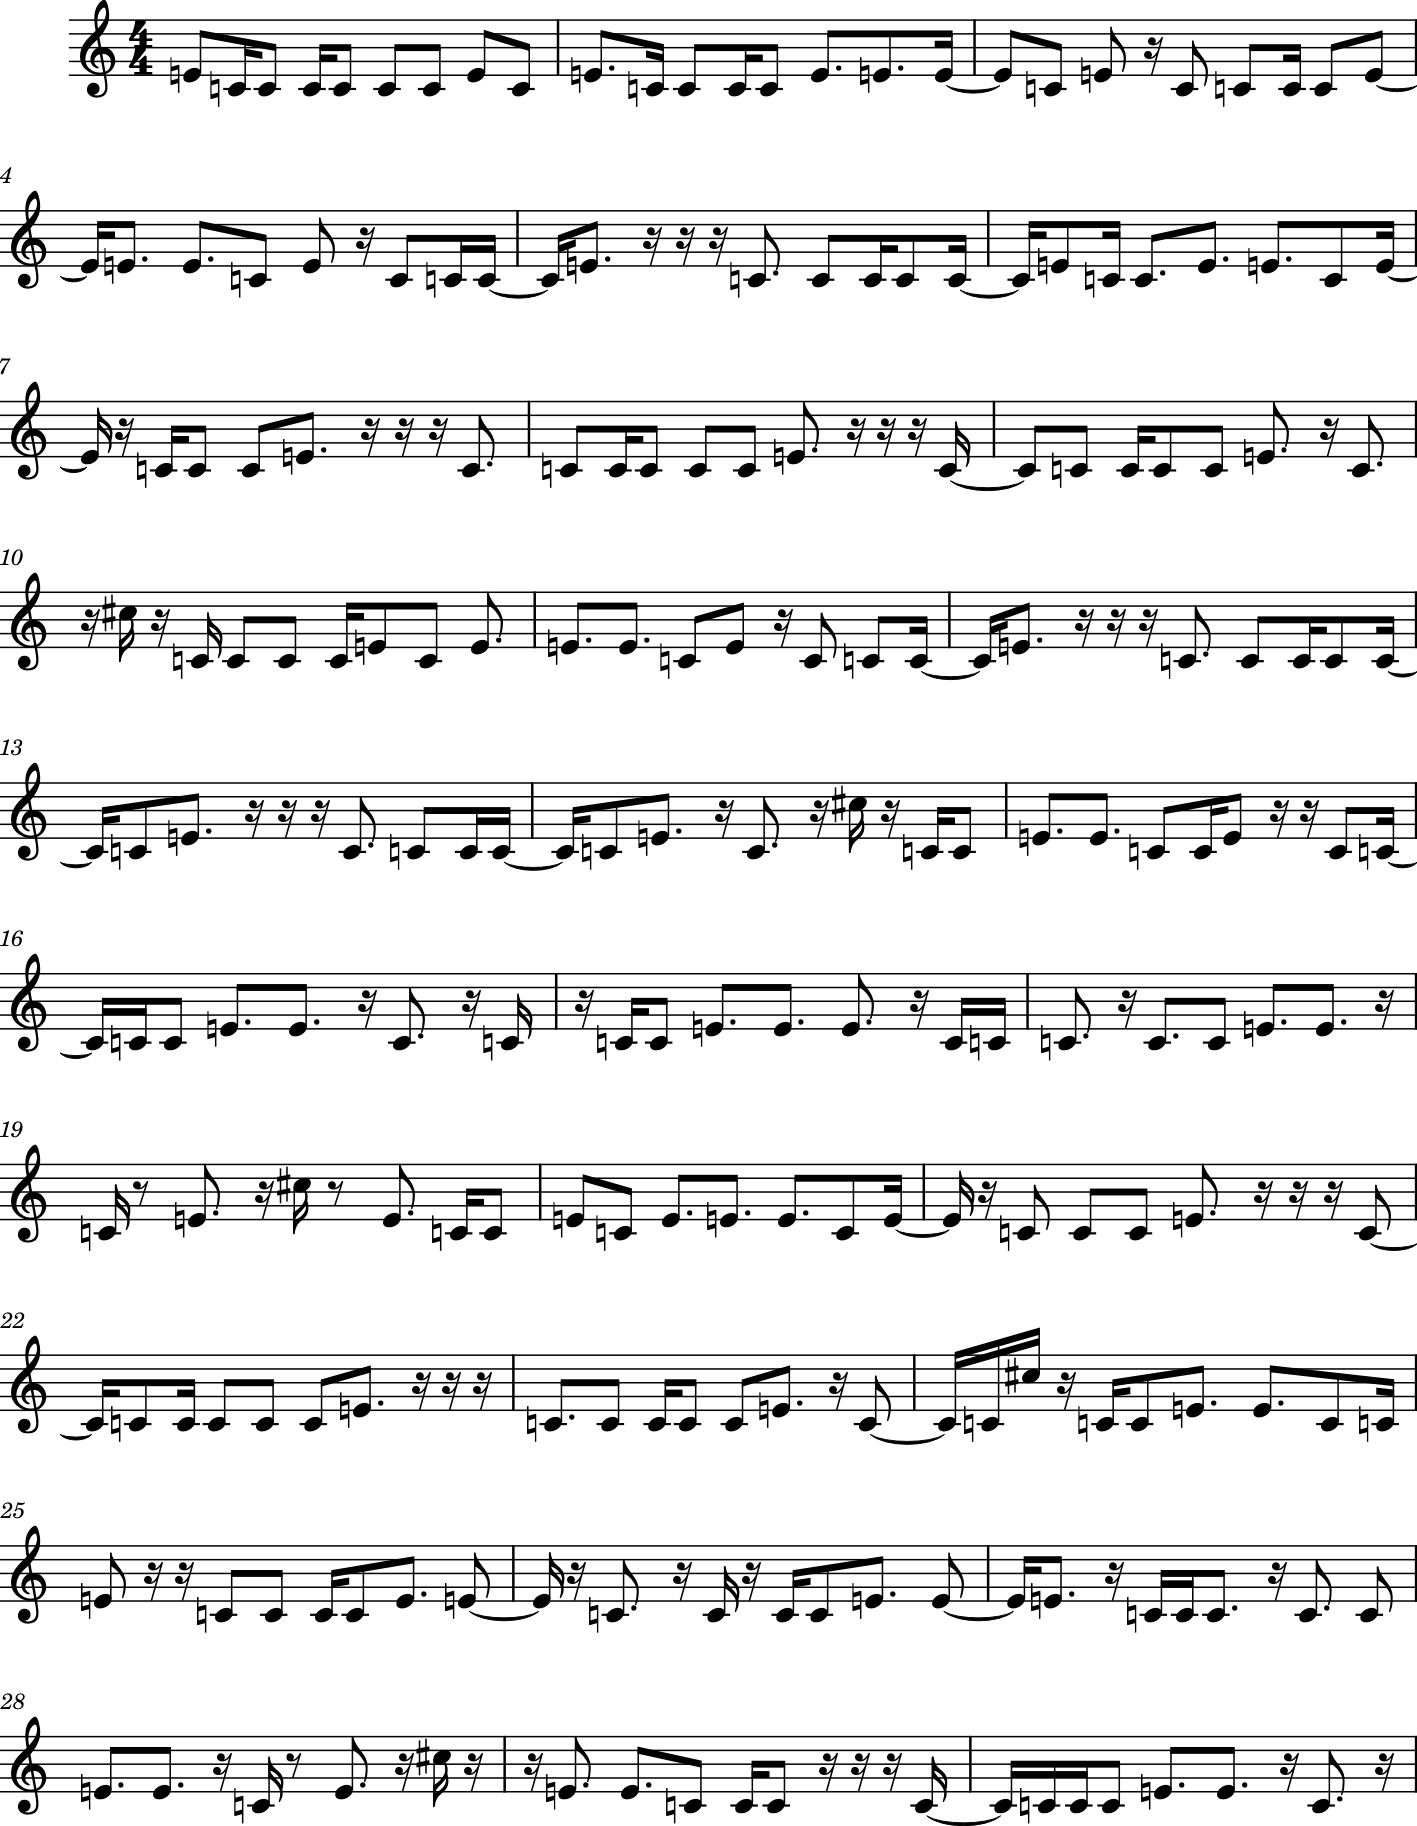

In [187]:
mus.show()

In [188]:
mus.show("midi")